In [1]:
!git clone https://github.com/cocodataset/cocoapi

fatal: destination path 'cocoapi' already exists and is not an empty directory.


In [2]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/cocoapi/PythonAPI')
os.getcwd()

'/content/cocoapi/PythonAPI'

In [4]:
!make

python setup.py build_ext --inplace
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I../common -I/usr/include/python3.7m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.7/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ clause does not guard... [-Wmisleading-ind

In [5]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import cv2
import PIL
import requests
from PIL import Image
import glob
import os

In [6]:
dataDir='/content/drive/My Drive/Deep_Learning/Homeworks/HW5'
dataType='val2014'
annFile='{}/instances_{}.json'.format(dataDir,dataType)

In [7]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=9.12s)
creating index...
index created!


In [14]:
os.chdir(dataDir)
classes_to_scrape = ['bus', 'horse', 'cat', 'dog', 'elephant']
if not os.path.exists('Val'):
		os.mkdir('Val')
root = os.path.join(dataDir, 'Val')
images_per_class = 100

In [15]:
##downloader with bbox
for i in range(len(classes_to_scrape)):
  catIds = coco.getCatIds(catNms=[classes_to_scrape[i]]);
  imgIds = coco.getImgIds(catIds=catIds );
  imgs = coco.loadImgs(imgIds)

  counter = 0
  class_name = classes_to_scrape[i]
	
  class_folder = os.path.join(root, class_name)
  if not os.path.exists(class_folder):
    os.mkdir(class_folder)

  os.chdir(root)	
  for im in imgs:
    counter += 1

    annIds=coco.getAnnIds(imgIds=im['id'],catIds=catIds,iscrowd=False)
    ann=coco.loadAnns(annIds)
    
    if len(ann) == 1:
    
      if counter > images_per_class:
        break
		
      os.chdir(class_folder)	

      filenames_before_download = os.listdir(class_folder)
		
      img_data = requests.get(im['coco_url']).content
      with open(im['file_name'], 'wb') as downloader:			
        downloader.write(img_data)
      
      name = im['file_name'][0:-4]
      
      img_file_path = os.path.join(class_folder, im['file_name'])
	
      im = Image . open ( img_file_path )
      
      if im.mode != "RGB":
        im = im.convert ( mode = "RGB" )

      I = io. imread ( img_file_path)
      image = np. uint8 (I)
      final_size = 128
      y_ratio = image.shape[0]/final_size
      x_ratio = image.shape[1]/final_size
      im_resized = im . resize (( final_size , final_size ) , Image . BOX )
		  # Overwrite original image with downsampled image
      im_resized . save ( img_file_path )	
    
      ##check if an image is already downloaded
      filenames_after_download = os.listdir(class_folder)

      ##add and save the bbox with the same name as the image
      [x,y,w,h] = (ann[0]['bbox'])
      x = x / x_ratio
      w = w / x_ratio
      y = y / y_ratio
      h = h / y_ratio
      
      filename = name+'.txt'
      np.savetxt(filename, np.array([x,y,w,h]), delimiter=',')
     
      saved_bbox = np.loadtxt(filename)
     
      I = io. imread ( img_file_path)
      image = np. uint8 (I)
      image = cv2 . rectangle (image , ( int (x), int (y)), ( int (x + w), int (y + h)), (36 ,255 ,12), 2)

      if len(filenames_before_download) == len(filenames_after_download):
        counter -= 1

    else:
      counter -= 1

In [16]:
import torch
from torch . utils . data import DataLoader , Dataset
import scipy
from scipy import misc
import os
import glob
import PIL
from PIL import Image
import numpy as np
from skimage import io, transform
import torch.nn.functional as F

class your_dataset_class(torch.utils.data.Dataset):
    def __init__ (self, root_path, class_list, transform) :
      self.path = root_path
      self.classes = class_list
      self.transform = transform 
      self.images = []
      self.bbox = []
      self.labels = []
      for i in range(0, len(self.classes)):
        os.chdir(self.path)
        os.chdir(self.classes[i])
        label = i
        bbox_files = glob.glob('*.txt')
        bbox_files.sort()
        image_files = glob.glob('*.jpg')
        image_files.sort()
        for filename in image_files:	
      	  self.images.append(self.transform(Image.open(filename)))
      	  self.labels.append(label)

        for filename in bbox_files:	
          saved_bbox = np.loadtxt(filename)
          bbox_member = []
          bbox_member.append(saved_bbox[0])
          bbox_member.append(saved_bbox[1])
          bbox_member.append(saved_bbox[2])
          bbox_member.append(saved_bbox[3])
          self.bbox.append(bbox_member)
			
      self.len = len(self.images)

    def __getitem__(self, index):
      return self.images[index], self.labels[index], torch.from_numpy(np.asarray(self.bbox[index]))

    def __len__(self):
      return self.len

In [17]:
from torchvision import transforms as tvt
transform = tvt . Compose ( [ tvt . ToTensor () , tvt . Normalize (( 0.5 ,0.5 ,0.5 ) , ( 0.5 , 0.5 , 0.5 ) ) ] )
val_dataset = your_dataset_class (root, classes_to_scrape, transform)

val_data_loader = torch.utils.data.DataLoader(dataset =
val_dataset ,
batch_size =  90, #val_dataset.__len__(),
shuffle = True ,
num_workers = 4 )
print (val_dataset.__len__()) 

500


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
''' Part of this code is borrowed from https://github.com/aladdinpersson and DLStudio module '''

import torch
import torch.nn as nn
import random
import matplotlib.pylab as plt

seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.becnhmarks = False
os.environ['PYTHONHASHSEED'] = str(seed)

dtype = torch . float64

device = torch . device ( "cuda:0" if torch.cuda.is_available() else "cpu" )

#classification + regression
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample, x_downsample):
    super().__init__()
    self.scale_factor = 2
    self.in_channels = in_channels
    self.conv1 = nn.Conv2d(self.in_channels, out_channels, kernel_size = 2, stride = 1, padding = 0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 2, stride = 1, padding = 1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.identity_downsample = identity_downsample
    self.x_downsample = x_downsample

  def forward(self, x):
    
    if self.identity_downsample is not None:
     x = self.identity_downsample(x)
     
    identity = x
    x = self.conv1(x)
    
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)

    x += identity
    x = self.relu(x)
    return x

class Net(nn.Module):
  def __init__(self, block, layers, original_channels, num_classes):
    super().__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(original_channels, self.in_channels, kernel_size = 3, stride = 1, padding = 1)
    self.bn1 = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

    self.block1 = self.__make_layer(block, layers[0], out_channels = 64)
    self.block2 = self.__make_layer(block, layers[1], out_channels = 128) 
    self.block3 = self.__make_layer(block, layers[2], out_channels = 256)

    self.fc1 = nn.Linear(256 * 16 * 16, 1000)
    self.fc2 = nn.Linear(1000, num_classes)

    ##Regression
    self.conv_seqn = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),nn.BatchNorm2d(64),nn.ReLU(inplace=True),
nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
nn.ReLU(inplace=True)
)
    
    self.fc_seqn = nn.Sequential(nn.Linear(262144, 1024),
nn.ReLU(inplace=True),
nn.Linear(1024, 512),
nn.ReLU(inplace=True),
nn.Linear(512, 4)
)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x1 = self.block1(x)
    x1 = self.block2(x1)
    x1 = self.block3(x1)

    x1 = x1.view(-1, 256 * 16 * 16)
    x1 = F.relu(self.fc1(x1))
    x1 = self.fc2(x1)

    ##REGRESSION
    x2 = self.conv_seqn(x)
    x2 = self.conv_seqn(x2)
    # flatten
    x2 = x2.view(x.size(0), -1)
    x2 = self.fc_seqn(x2)
    return x1, x2

  def __make_layer(self, block, num_blocks, out_channels):
    identity_downsample = None
    x_downsample = None
    layers = []

    if self.in_channels != out_channels:
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels, kernel_size = 1, stride = 2) , nn.BatchNorm2d(out_channels) )
      x_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels//2, kernel_size = 1, stride = 2) , nn.BatchNorm2d(out_channels//2) )
      
    self.in_channels = out_channels
    layers.append(block(self.in_channels, out_channels, identity_downsample, x_downsample))

    for i in range(num_blocks - 1):
      identity_downsample = None
      layers.append(block(self.in_channels, out_channels, identity_downsample, x_downsample))

    return nn.Sequential(*layers)

In [19]:
os.chdir(dataDir)
block_net = Net(block, [2, 3, 2], 3, 5)
PATH = 'net.pth'
block_net.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
block_net.eval()

predictions = []
for i, data in enumerate(val_data_loader):
      inputs, labels, bbox = data 
      #inputs, labels, bbox = inputs.cuda(), labels.cuda(), bbox.cuda()
      inputs = inputs.to(device)
      labels = labels.to(device)
      bbox_true = bbox.to(device).float()
      outputs = block_net(inputs)
      outputs_label = outputs[0] 
      bbox_pred = outputs[1]

for i in range(outputs_label.shape[0]):
	predictions.append(torch.argmax(outputs_label[i]))

labels = np.array(labels)
predictions = np.array(predictions)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


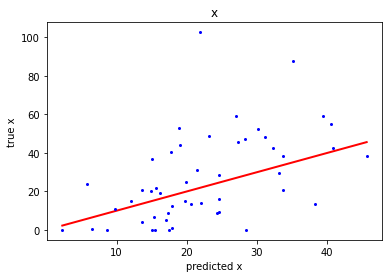

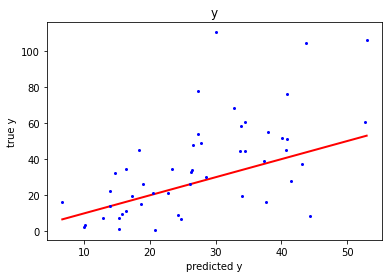

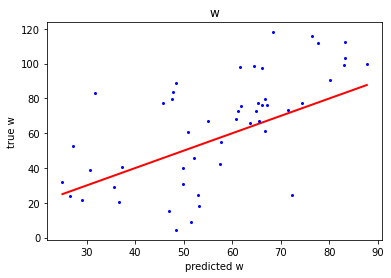

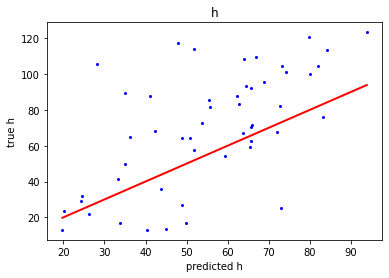

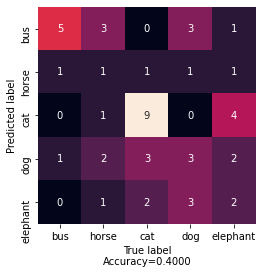

In [21]:
import seaborn as sns			
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
os.chdir(dataDir)

#x
x_pred = []
x_true = []
for i in range(len(bbox_pred)):
  x_pred.append(bbox_pred[i].detach().numpy()[0])
  x_true.append(bbox_true[i].detach().numpy()[0])

plt.figure(1)
y_range = np.linspace(np.min(x_pred), np.max(x_pred), 50)
plt.plot(y_range, y_range, 'r', lw=2)
plt.plot(x_pred, x_true, 'bo', markersize = 2, clip_on = False)
plt.xlabel('predicted x')
plt.ylabel('true x')
plt.title('x')
plt.savefig('validation_x.jpg', bbox_inches = 'tight', pad_inches = 0)

#y
y_pred = []
y_true = []
for i in range(len(bbox_pred)):
  y_pred.append(bbox_pred[i].detach().numpy()[1])
  y_true.append(bbox_true[i].detach().numpy()[1])

plt.figure(2)
y_range = np.linspace(np.min(y_pred), np.max(y_pred), 50)
plt.plot(y_range, y_range, 'r', lw=2)
plt.plot(y_pred, y_true, 'bo', markersize = 2, clip_on = False)
plt.xlabel('predicted y')
plt.ylabel('true y')
plt.title('y')
plt.savefig('validation_y.jpg', bbox_inches = 'tight', pad_inches = 0)

#w
w_pred = []
w_true = []
for i in range(len(bbox_pred)):
  w_pred.append(bbox_pred[i].detach().numpy()[2])
  w_true.append(bbox_true[i].detach().numpy()[2])

plt.figure(3)
y_range = np.linspace(np.min(w_pred), np.max(w_pred), 50)
plt.plot(y_range, y_range, 'r', lw=2)
plt.plot(w_pred, w_true, 'bo', markersize = 2, clip_on = False)
plt.xlabel('predicted w')
plt.ylabel('true w')
plt.title('w')
plt.savefig('validation_w.jpg', bbox_inches = 'tight', pad_inches = 0)

#h
h_pred = []
h_true = []
for i in range(len(bbox_pred)):
  h_pred.append(bbox_pred[i].detach().numpy()[3])
  h_true.append(bbox_true[i].detach().numpy()[3])

plt.figure(4)
y_range = np.linspace(np.min(h_pred), np.max(h_pred), 50)
plt.plot(y_range, y_range, 'r', lw=2)
plt.plot(h_pred, h_true, 'bo', markersize = 2, clip_on = False)
plt.xlabel('predicted h')
plt.ylabel('true h')
plt.title('h')
plt.savefig('validation_h.jpg', bbox_inches = 'tight', pad_inches = 0)

#confusion matrix
score = accuracy_score(labels, predictions)

mat = confusion_matrix(labels, predictions)
index = classes_to_scrape
columns = classes_to_scrape
import pandas as pd
plt.figure(0)
mat_df = pd.DataFrame(mat, columns, index)
sns.heatmap(mat_df.T, square=True, annot=True, fmt = 'd', cbar = False)
plt.ylabel('Predicted label')
plt.xlabel('True label\nAccuracy={:0.4f}'.format(score))
plt.savefig('validation_confusion_matrix.jpg', bbox_inches = 'tight', pad_inches = 0)